In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['koi_disposition'].value_counts()}")

Dataset shape: (9564, 49)
Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


## Program 7: k-Nearest Neighbors (k-NN) — Exoplanet Classification

**Scientific Background:**  
k-NN is the most intuitive classifier: a new signal is classified by
looking at its **k most similar signals** in the training data.

In astrophysical terms: *"If a Kepler signal looks like its k nearest
neighbors in orbital and stellar parameter space, and most of them are
confirmed planets, it's probably a planet too."*

This is analogous to how astronomers historically classified stars —
by comparing unknown spectra to known reference stars.

**Key questions we'll investigate:**
- What is the optimal k for this dataset?
- How does performance change as k increases?
- Which signals are hardest to classify (boundary cases)?

In [2]:
data = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
data['label'] = (data['koi_disposition'] == 'CONFIRMED').astype(int)

features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad',
            'koi_prad', 'koi_teq']

data = data[features + ['label']].dropna()
print(f"Usable rows: {len(data)}")

X = data[features].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# k-NN is extremely sensitive to scale — mandatory scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Usable rows: 7326
Train: 5860 | Test: 1466


In [3]:
# Test multiple k values
k_values = list(range(1, 31, 2))  # 1, 3, 5, ..., 29
accuracies = []
auc_scores = []

print("Testing k values...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    y_prob_k = knn.predict_proba(X_test_scaled)[:, 1]
    accuracies.append(accuracy_score(y_test, y_pred_k))
    auc_scores.append(roc_auc_score(y_test, y_prob_k))
    print(f"  k={k:2d}: Accuracy={accuracies[-1]*100:.2f}%  AUC={auc_scores[-1]:.4f}")

best_k = k_values[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"\nBest k = {best_k} with accuracy = {best_acc*100:.2f}%")

Testing k values...
  k= 1: Accuracy=81.92%  AUC=0.8149
  k= 3: Accuracy=82.95%  AUC=0.8869
  k= 5: Accuracy=84.11%  AUC=0.9106
  k= 7: Accuracy=84.24%  AUC=0.9137
  k= 9: Accuracy=84.79%  AUC=0.9180
  k=11: Accuracy=84.86%  AUC=0.9215
  k=13: Accuracy=85.20%  AUC=0.9228
  k=15: Accuracy=84.92%  AUC=0.9246
  k=17: Accuracy=85.20%  AUC=0.9252
  k=19: Accuracy=84.92%  AUC=0.9268
  k=21: Accuracy=84.86%  AUC=0.9275
  k=23: Accuracy=84.92%  AUC=0.9286
  k=25: Accuracy=85.06%  AUC=0.9278
  k=27: Accuracy=84.86%  AUC=0.9279
  k=29: Accuracy=84.72%  AUC=0.9274

Best k = 13 with accuracy = 85.20%


In [4]:
# Train final model with best k
model = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric='euclidean')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("=" * 50)
print(f"      k-NN RESULTS (k={best_k})")
print("=" * 50)
print(f"  k neighbors  : {best_k}")
print(f"  Weight       : distance (closer = more influence)")
print(f"  Metric       : Euclidean distance")
print(f"  Accuracy     : {acc:.4f} ({acc*100:.2f}%)")
print(f"  ROC-AUC      : {auc:.4f}")
print("=" * 50)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=['FALSE POSITIVE', 'CONFIRMED']))

      k-NN RESULTS (k=13)
  k neighbors  : 13
  Weight       : distance (closer = more influence)
  Metric       : Euclidean distance
  Accuracy     : 0.8520 (85.20%)
  ROC-AUC      : 0.9228

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.92      0.84      0.88       917
     CONFIRMED       0.76      0.88      0.82       549

      accuracy                           0.85      1466
     macro avg       0.84      0.86      0.85      1466
  weighted avg       0.86      0.85      0.85      1466



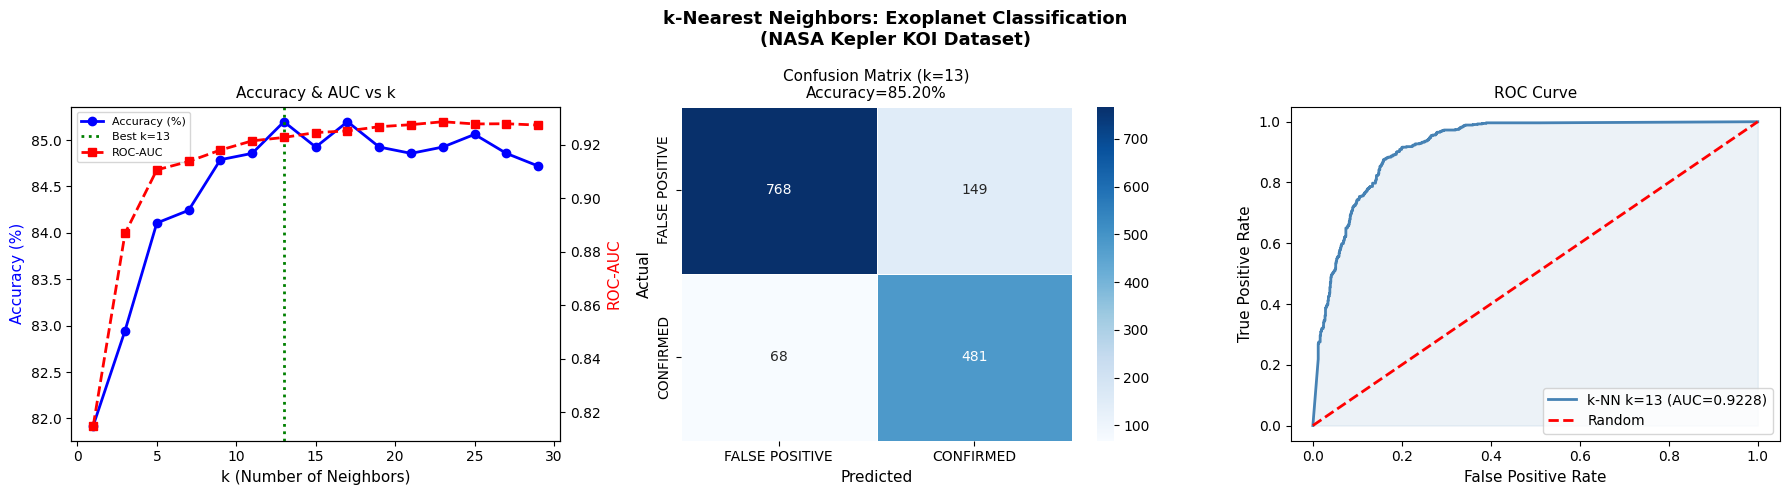

Plot saved!


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('k-Nearest Neighbors: Exoplanet Classification\n(NASA Kepler KOI Dataset)',
             fontsize=13, fontweight='bold')

# Plot 1: Accuracy and AUC vs k
axes[0].plot(k_values, [a*100 for a in accuracies], 'bo-', lw=2,
             markersize=6, label='Accuracy (%)')
ax0_twin = axes[0].twinx()
ax0_twin.plot(k_values, auc_scores, 'rs--', lw=2, markersize=6, label='ROC-AUC')
axes[0].axvline(best_k, color='green', linestyle=':', lw=2, label=f'Best k={best_k}')
axes[0].set_xlabel('k (Number of Neighbors)', fontsize=11)
axes[0].set_ylabel('Accuracy (%)', color='blue', fontsize=11)
ax0_twin.set_ylabel('ROC-AUC', color='red', fontsize=11)
axes[0].set_title('Accuracy & AUC vs k', fontsize=11)
lines1, labels1 = axes[0].get_legend_handles_labels()
lines2, labels2 = ax0_twin.get_legend_handles_labels()
axes[0].legend(lines1 + lines2, labels1 + labels2, fontsize=8)

# Plot 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            yticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            linewidths=0.5)
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_title(f'Confusion Matrix (k={best_k})\nAccuracy={acc*100:.2f}%', fontsize=11)

# Plot 3: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[2].plot(fpr, tpr, color='steelblue', lw=2, label=f'k-NN k={best_k} (AUC={auc:.4f})')
axes[2].plot([0, 1], [0, 1], 'r--', lw=2, label='Random')
axes[2].fill_between(fpr, tpr, alpha=0.1, color='steelblue')
axes[2].set_xlabel('False Positive Rate', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontsize=11)
axes[2].set_title('ROC Curve', fontsize=11)
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/plots/07_knn.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved!")

In [6]:
print("k-NN: Scientific Interpretation")
print("=" * 55)
print(f"""
k-NN classifies each Kepler signal by finding its {best_k}
most similar signals in orbital/stellar parameter space.

Optimal k = {best_k} (found by testing k = 1 to 29):
  • Small k (1-3): Overfits — too sensitive to individual noisy signals
  • Large k (>15): Underfits — neighborhoods too broad, loses local structure
  • k={best_k}: Best balance between bias and variance

Distance weighting (weights='distance'):
  Closer neighbors have more voting power than distant ones.
  This is physically meaningful — a signal that is nearly
  identical to a confirmed planet should be trusted more.

Performance Summary So Far:
  • Naive Bayes        : 71.01%
  • Logistic Regression: 74.01%
  • SVM (RBF)          : 84.45%
  • k-NN (k={best_k:<2d})       : {acc*100:.2f}%
  • Decision Tree      : 87.59%

ROC-AUC = {auc:.4f}
""")

k-NN: Scientific Interpretation

k-NN classifies each Kepler signal by finding its 13
most similar signals in orbital/stellar parameter space.

Optimal k = 13 (found by testing k = 1 to 29):
  • Small k (1-3): Overfits — too sensitive to individual noisy signals
  • Large k (>15): Underfits — neighborhoods too broad, loses local structure
  • k=13: Best balance between bias and variance

Distance weighting (weights='distance'):
  Closer neighbors have more voting power than distant ones.
  This is physically meaningful — a signal that is nearly
  identical to a confirmed planet should be trusted more.

Performance Summary So Far:
  • Naive Bayes        : 71.01%
  • Logistic Regression: 74.01%
  • SVM (RBF)          : 84.45%
  • k-NN (k=13)       : 85.20%
  • Decision Tree      : 87.59%

ROC-AUC = 0.9228

